In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import CRS, Transformer
from matplotlib.colors import Normalize, ListedColormap
from shapely.geometry import Point

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [11]:
def add_inset_map(ax, gdf, lon1, lat1, lon2, lat2):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    transformer_inset = Transformer.from_crs('EPSG:4326', 'EPSG:3857')
    iax = inset_axes(ax, width="30%", height="33%", loc=1)
    inset_xmin, inset_ymin = transformer_inset.transform(lat2, lon2)
    inset_xmax, inset_ymax = transformer_inset.transform(lat1, lon1)
    iax.set_xlim(min(inset_xmin, inset_xmax), max(inset_xmin, inset_xmax))
    iax.set_ylim(min(inset_ymin, inset_ymax), max(inset_ymin, inset_ymax))
    ctx.add_basemap(iax, source=ctx.providers.OpenTopoMap, zoom=12, attribution_size=0)
    # Get the extent of the main map
    main_xmin, main_xmax =  ax.get_xlim() 
    main_ymin, main_ymax =  ax.get_ylim()
    # Draw a rectangle as a closed box using a line
    iax.plot([main_xmin, main_xmin, main_xmax, main_xmax, main_xmin],
             [main_ymin, main_ymax, main_ymax, main_ymin, main_ymin],
             color='red', linewidth=1.5, linestyle='-')
    iax.set_xticks([]), iax.set_yticks([])

In [7]:
def process_file(file_name, element):
    # Import the CSV file into a DataFrame + Convert DataFrame to GeoDataFrame
    df = pd.read_csv(file_name)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs='EPSG:4326')

    # Convert coordinate reference system
    gdf_mercator = gdf.to_crs(epsg=3857)
    control_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([control_x], [control_y]), crs='EPSG:4326').to_crs(epsg=3857)

    # Compute differences in coordinates and concentrations
    dx = gdf_mercator.geometry.x - control_gdf.geometry.x.iloc[0]
    dy = gdf_mercator.geometry.y - control_gdf.geometry.y.iloc[0]
    d_element = df[element] - control_concentration  # Change element here
    #d_element=d_element*-1

    # Compute distance between points and control points
    distance = np.sqrt(dx**2 + dy**2)

    # Compute the change in contamination per unit distance
    delta_element_deltaX = d_element / distance

    # Normalize for color mapping
    delta_element_deltaX_normalized = (delta_element_deltaX - delta_element_deltaX.min()) / (delta_element_deltaX.max() - delta_element_deltaX.min())

    # Create a vector (dx, dy) that represents the direction from each point to the control point
    dx_normalized = dx / distance
    dy_normalized = dy / distance

    # Multiply the normalized direction vector by the gradient magnitude to create a vector
    dx_gradient = dx_normalized * delta_element_deltaX
    dy_gradient = dy_normalized * delta_element_deltaX
    
    return gdf_mercator, control_gdf, dx_gradient, dy_gradient, delta_element_deltaX, delta_element_deltaX_normalized

In [4]:
def plot_contamination_map(file_name, element, margin, lon1, lat1, lon2, lat2):
    
    gdf_mercator, control_gdf, dx_gradient, dy_gradient, delta_element_deltaX, delta_element_deltaX_normalized = process_file(file_name, element)

    # Create colormap
    N = 10
    cmap = ListedColormap([plt.cm.viridis(i/N) for i in range(N)])

    fig, ax = plt.subplots(figsize=(14, 14))

    # Plot the points and setup figure
    gdf_mercator.plot(ax=ax, alpha=1, edgecolor='k')
    ax.scatter(control_gdf.geometry.x, control_gdf.geometry.y, color='blue')

    # Use quiver to plot the arrows, color-coded by contamination difference
    q = ax.quiver(gdf_mercator.geometry.x, gdf_mercator.geometry.y, dx_gradient, dy_gradient, scale=20, color=cmap(delta_element_deltaX_normalized), linewidths=delta_element_deltaX)

    # Add a colorbar
    norm = Normalize(vmin=delta_element_deltaX.min(), vmax=delta_element_deltaX.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.4)
    colorbar.set_label(f'Change in {element} concentration (ppm/m)')  # Replaced 'Mn' with {element}
    colorbar.set_ticks(np.linspace(np.round(delta_element_deltaX.min(), 2), np.round(delta_element_deltaX.max(), 2), num=10))

    # Set the map extent based on the points, with increased margin
    xmin, ymin, xmax, ymax = gdf_mercator.total_bounds
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)

    # Set the basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

    # Calculate longitude and latitude for tick locations, set labels, etc.
    xticks = np.linspace(xmin - margin, xmax + margin, num=5)
    yticks = np.linspace(ymin - margin, ymax + margin, num=5)
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    xticklabels = [round(transformer.transform(x, ymin)[1], 4) for x in xticks]
    yticklabels = [round(transformer.transform(xmin, y)[0], 4) for y in yticks]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('Soil Sample Locations and Contamination Relative to Control Site')


    add_inset_map(ax, control_gdf, lon1, lat1, lon2, lat2) # Add inset map

    plt.savefig(f"./plots/contamination_map_{element}.png", dpi=300)

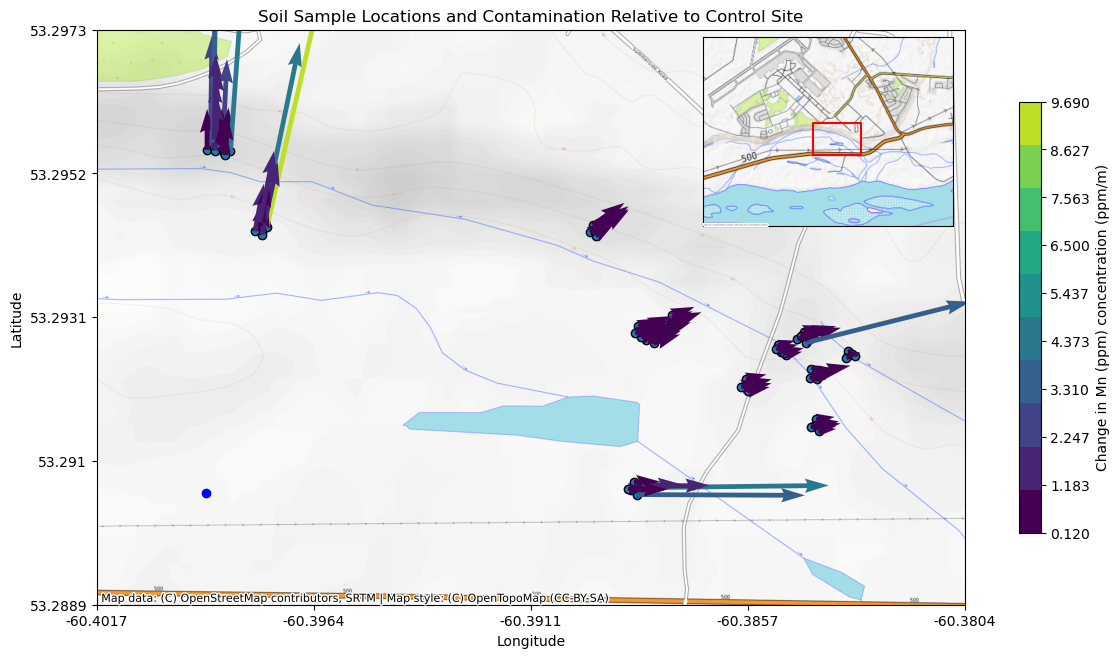

In [12]:
# Global settings

control_x, control_y = -60.399, 53.2905
control_concentration = 200
margin = 300  # Change this value as needed to increase the size of the main map bounds

filename = 'soil_samples_Mn.csv'
element = 'Mn (ppm)'

# Inset map size
lat2, lon2 = 53.32, -60.34
lat1, lon1 = 53.27, -60.45

plot_contamination_map(filename,element, margin, lon1, lat1, lon2, lat2)